This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display

from stochastic_models import model_bistable2
from stochastic_tests import Test
import stochastic_repro as sr

t_fin = 10.0
num_steps = 1000
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000])

a1_mean = 0.9
a2_mean = 1.1

test1 = Test(model=model_bistable2({'a': ('norm', (a1_mean, 0.2))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_bistable2({'a': ('norm', (a2_mean, 0.2))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

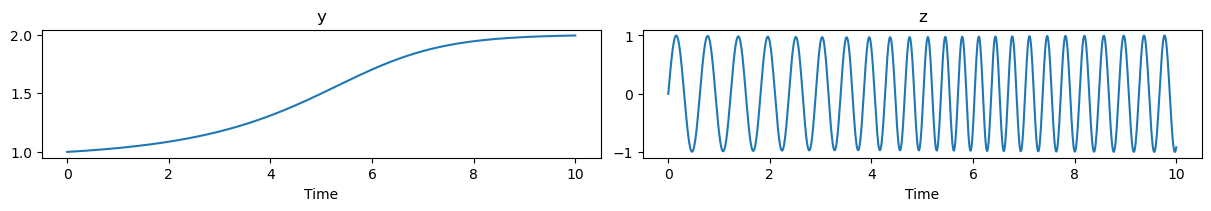

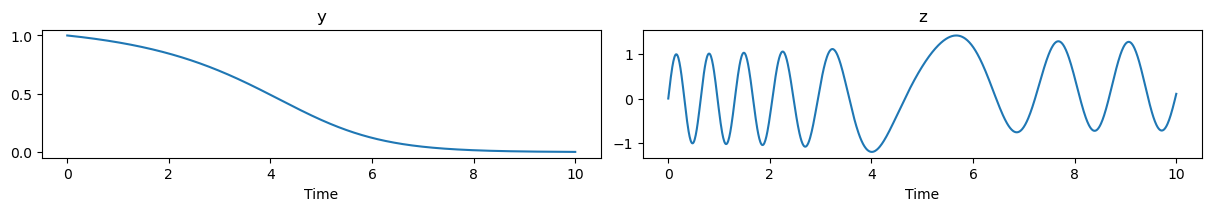

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

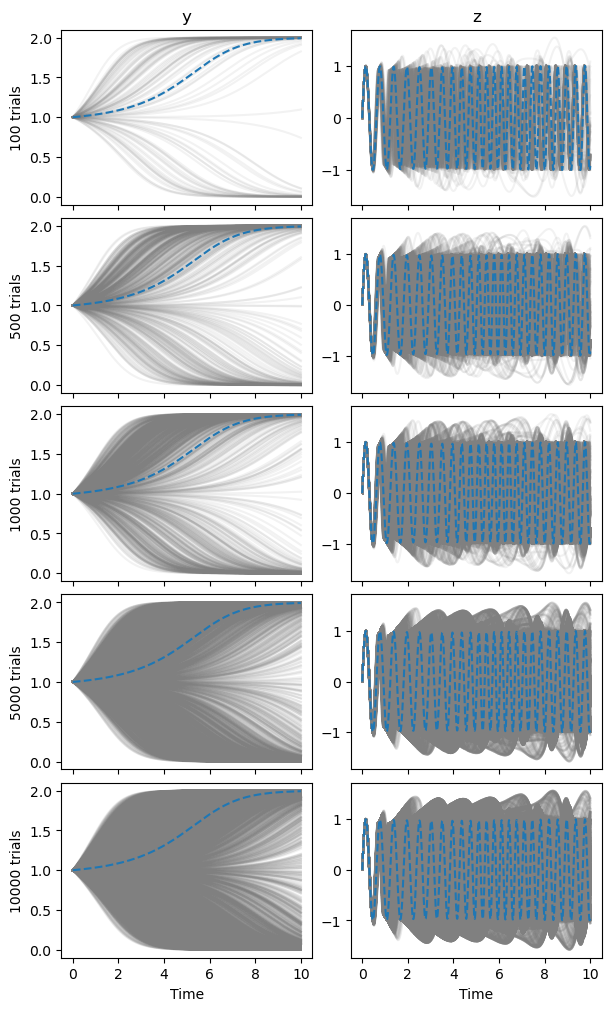

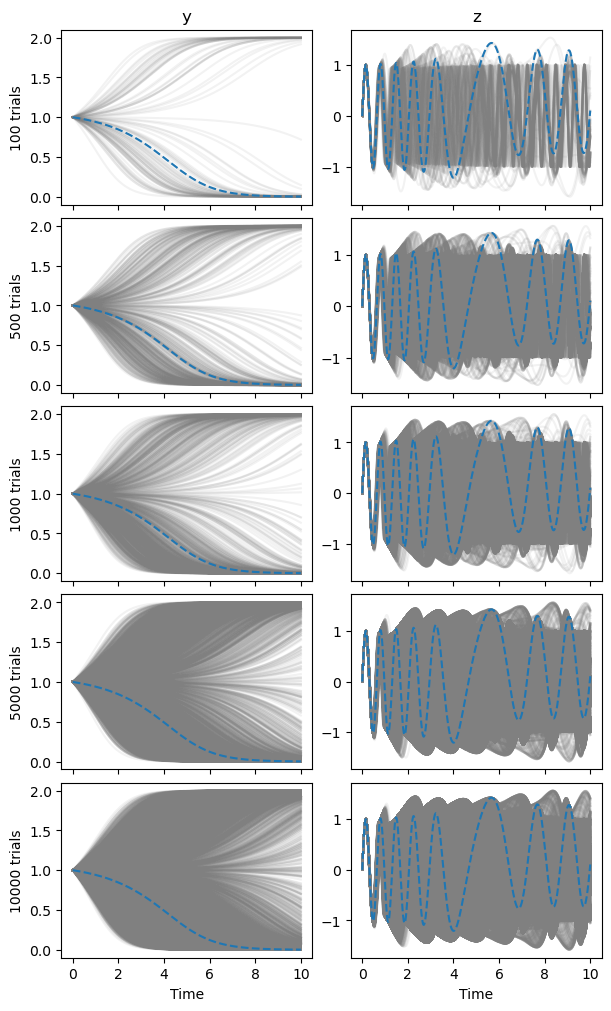

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

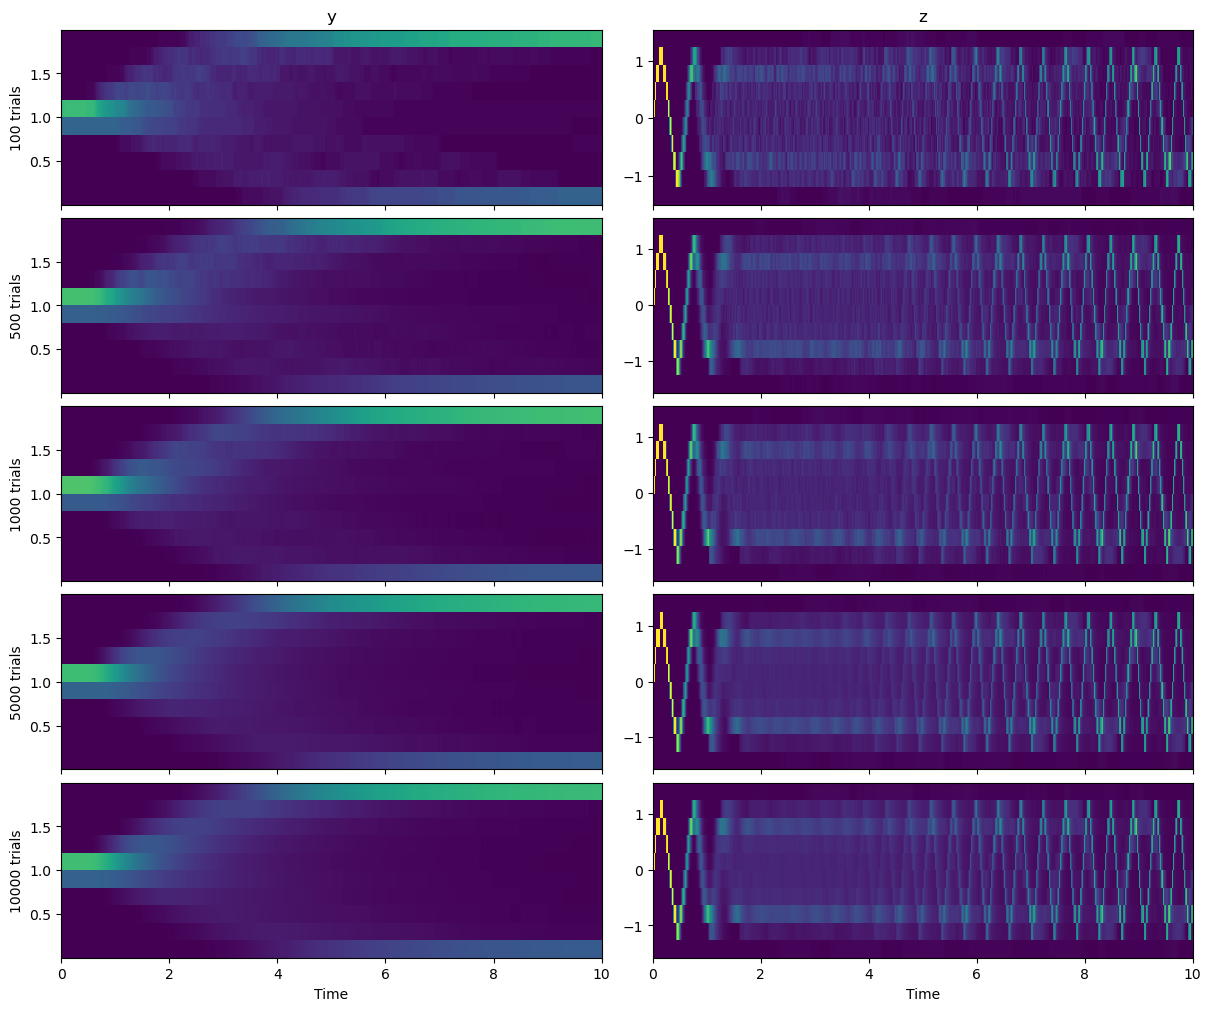

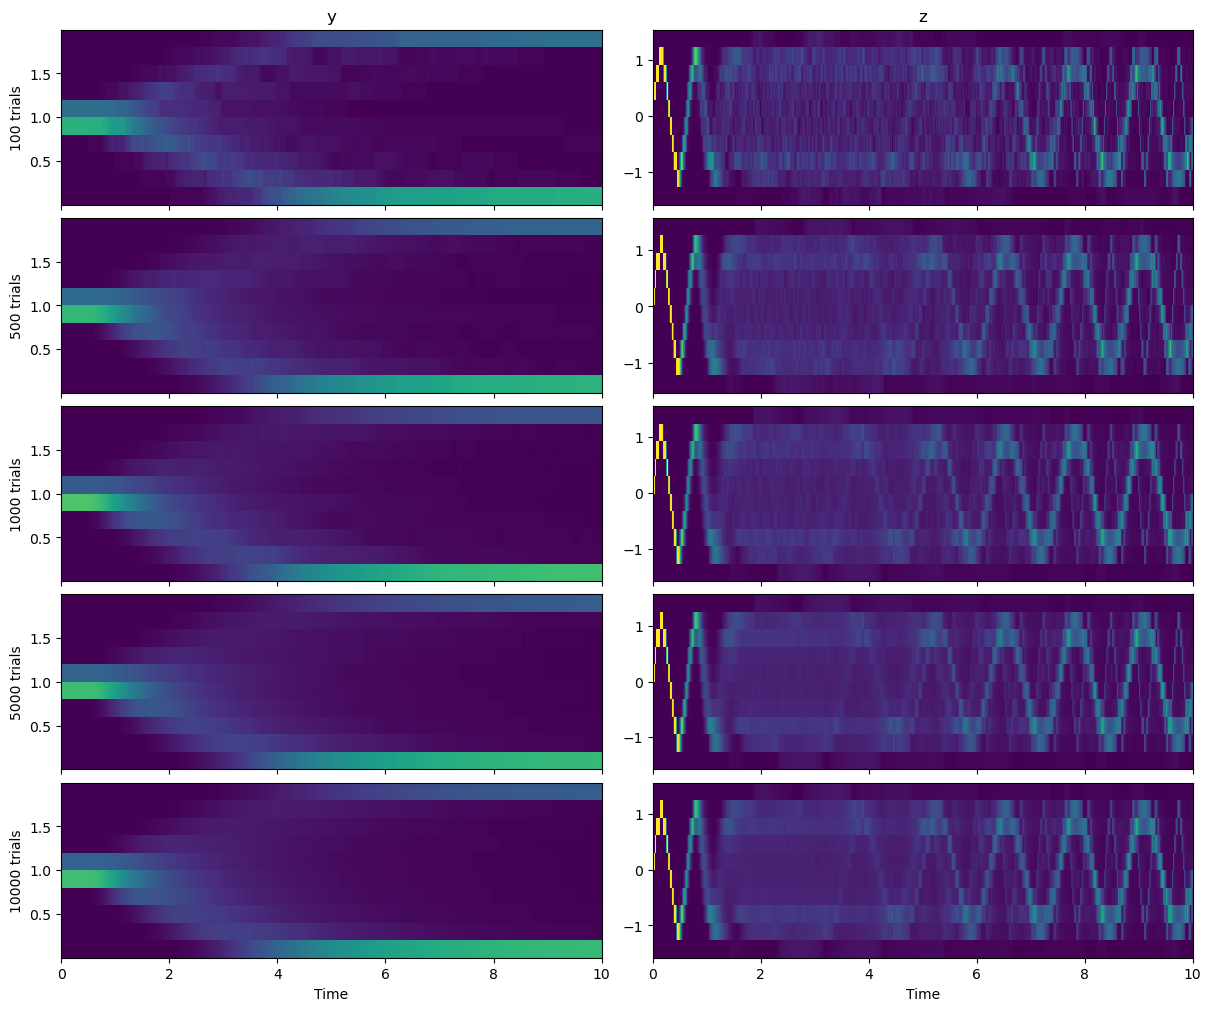

In [5]:
for test in tests:
    _ = test.plot_distributions()

/Users/timothy.sego/Desktop/Current/stochastic_repro/stochastic_repro.py:946: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(fit_func, data_x, data_y, **kwargs)


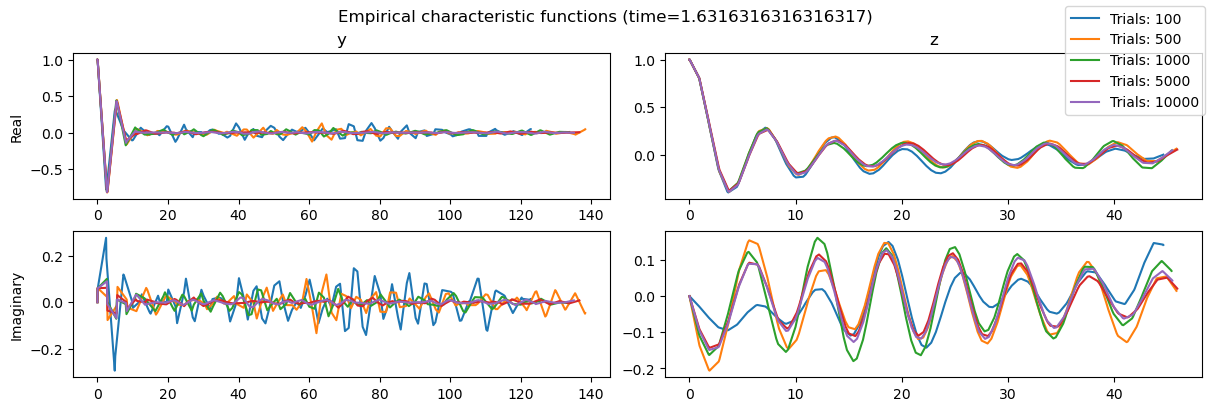

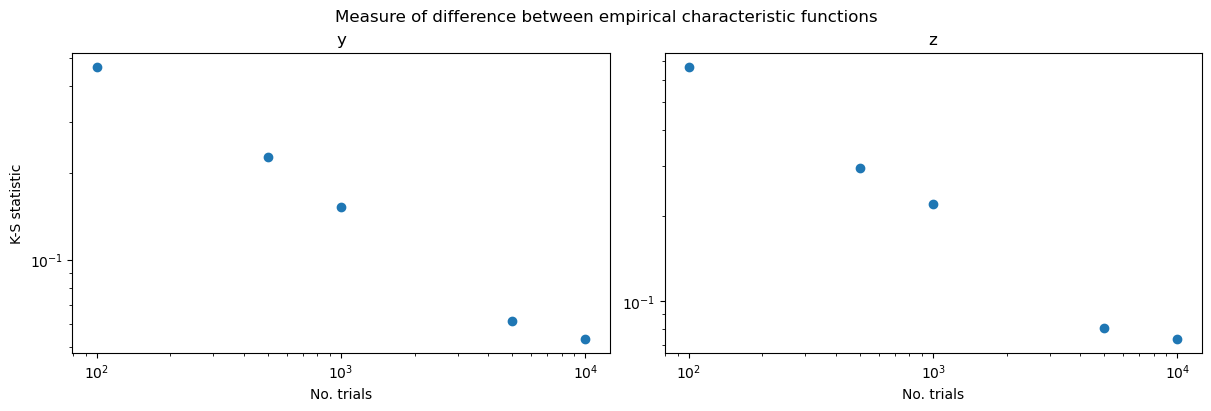

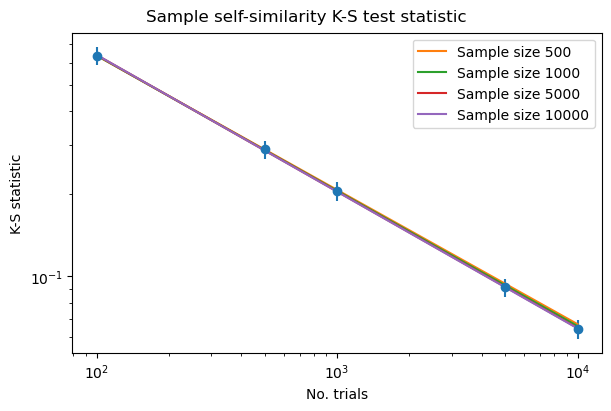

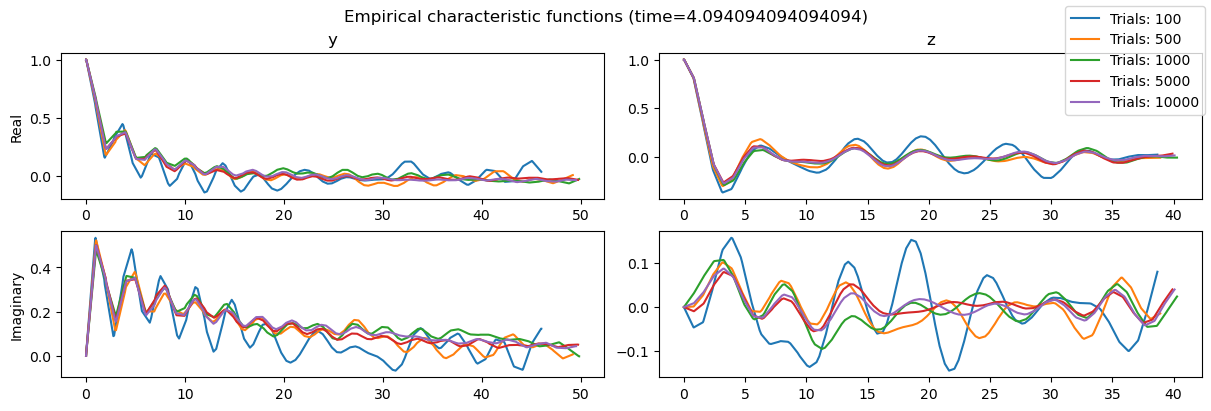

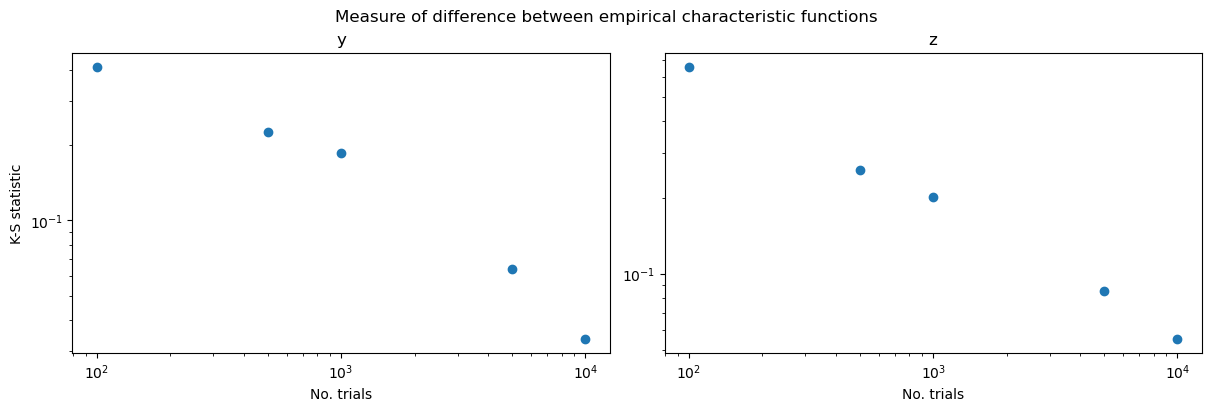

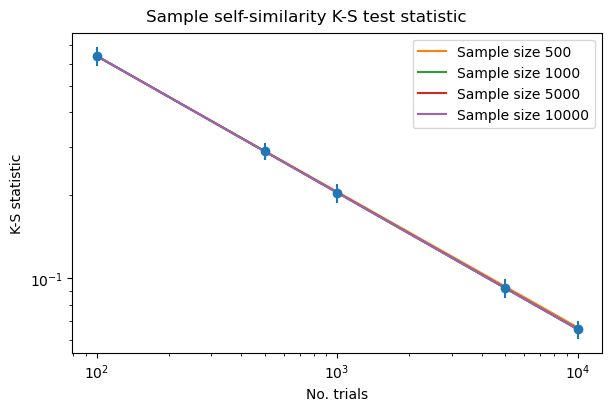

In [6]:
# Runtime: ~159 minutes (M1 max)
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

Text(0.5, 0.98, 'Measure of empirical characteristic functions')

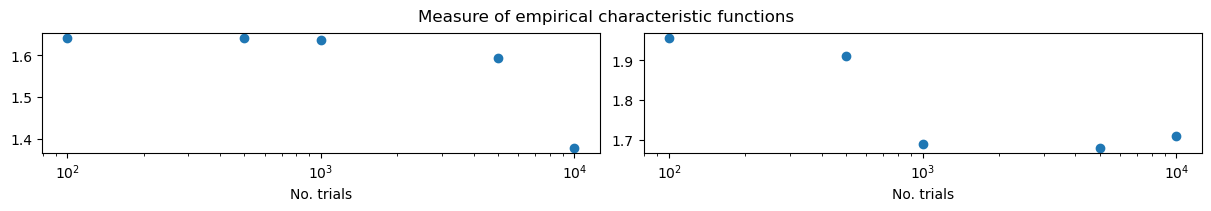

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('No. trials')
    ax[i].set_xscale('log')
fig.suptitle('Measure of empirical characteristic functions')

Testing for how well the method can detect differences in model parameters. 

Output()

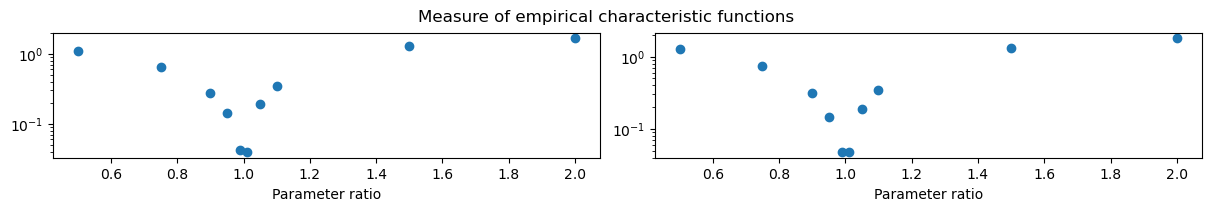

In [8]:
a_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.01, 1.05, 1.1, 1.5, 2.0]
a_test_kwargs = test_kwargs.copy()
a_test_kwargs['trials'] = [test_kwargs['trials'][-1]]
a_comp = list()

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for af in a_fact:
    label.value = f'Factor: {af}...'

    atest_mean = a1_mean * af
    test = Test(model=model_bistable2({'a': ('norm', (atest_mean, 0.2))}), stochastic=False, **test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.sample_times, test1.model.results_names, test1.trials, test1.ecf_eval_info)
    a_comp.append(sr.measure_ecf_diff_sets(test1.ecf, ecf2))

out.clear_output()

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(a_fact, [max([el[name] for el in diff[test1.trials[-1]]]) for diff in a_comp])
    ax[i].set_xlabel('Parameter ratio')
    ax[i].set_yscale('log')
_ = fig.suptitle('Measure of empirical characteristic functions')